# Analyzing How Steam Has Matured

The goal and direction of this project is to **analyze how the Steam marketplace has matured and developed over time**.  

Some of the key questions I aim to answer are:

- 📈 **Growth:** How has Steam grown over time?
- 💲 **Pricing:** How have prices changed over time?
- ⭐ **Quality:** How have ratings evolved? Is there a relationship between price and rating?
- 💻 **Platform Support:** How has Steam's support for Windows, macOS, and Linux changed over time?

---
### 📊 Analysis & Methodology

1️⃣ **Growth**:  How many games were released per year, and what does that say about Steam's overall market expansion?

2️⃣ **Pricing Evolution**: How have average and median prices of games changed over time?

3️⃣ **Quality**: How have ratings changed per year, and is there a correlation between price and rating?

4️⃣ **Accessibility**: How has platform support changed over time? Is Steam becoming more inclusive for non-Windows users?

## Section 1: Data Preprocessing 

In [483]:
# Start by importing necessary libraries. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import concat
from datetime import date

To get started, we need to import the dataset for this analysis. It can be found inside the .zip folder of this notebook, or, on kaggle.com at https://www.kaggle.com/datasets/benjaminlundkvist/steam-sales-historical-dataset. 

- **DISCLAIMER**: Dataset updates weekly on Kaggle. This notebook is built using the dataset that was updated on September 8th, 2025.

In [484]:
# Load & prepare data.
steam_sales = pd.read_csv('steam_sales_Sep8.csv')
steam_sales.head()

,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
0,PEAK,7.0,"77,683",-38.0,4.64,7.49,"16 Jun, 2025",1,0,0,2025-08-11 00:00
1,Cyberpunk 2077,7.0,"772,574",-65.0,20.99,59.99,"9 Dec, 2020",1,0,1,2025-08-11 00:00
2,Rust,7.0,"1,038,433",-50.0,19.99,39.99,"8 Feb, 2018",1,0,1,2025-08-11 00:00
3,Microsoft Flight Simulator (2020) 40th Anniver...,5.0,"63,905",-60.0,27.99,69.99,"17 Aug, 2020",1,0,0,2025-08-11 00:00
4,Sid Meier's Civilization VII,4.0,"34,643",-30.0,48.99,69.99,"10 Feb, 2025",1,1,1,2025-08-11 00:00


Before we proceed, we'll check if we have any null values, and verify our data types. 

In [485]:
# Checking row quantity. 
print("Row count:", steam_sales.shape[0])

# Checking for null values.
print("Null Values?", steam_sales.isnull().values.any())

# Verifying data type.
print("-----------------------------")
print(steam_sales.dtypes.to_string())

Row count: 1435
Null Values? False
-----------------------------
Game Name              object
Rating                float64
#Reviews               object
Discount%             float64
Price (€)             float64
Original Price (€)    float64
Release Date           object
Windows                 int64
Linux                   int64
MacOS                   int64
Fetched At             object


No null values! This dataset is directly from Steam api, and is updated weekly, so the absence of null values is expected. 

Release Date & Reviews column are stored as objects (strings). For the purposes of this project, we'll convert Reviews to numeric, as it represents quantitative data, and Release Date to datetime, to take advantage of pandas time & date capabilities. 

In [486]:
# Convert Reviews to numeric.
steam_sales['#Reviews'] = pd.to_numeric(steam_sales['#Reviews'].str.replace(',', ''))
print(steam_sales['#Reviews'].dtypes)

float64


Attempting a similar conversion with the Release Date column returns either an error or null values.

In [487]:
steam_sales['Release Date'].iloc[[377, 378]]

377     9 Apr, 2008
378    Jun 16, 2025
Name: Release Date, dtype: object

Since there appear to be 2 different date formats, and they switch at a specific index, we'll try splitting the column by the different formats, and stack them. 

In [488]:
# Convert Release Date to datetime. 
date_format_1 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%b %d, %Y').dropna()
date_format_2 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%d %b, %Y').dropna()
converted_date = pd.concat([date_format_2, date_format_1]) # The dataset switches date format at the 378th index, date_format 1 & 2 can be stacked.  

# Ensure converted & original dates align.
print(pd.DataFrame ({"steam_sales": steam_sales['Release Date'], "converted_date": converted_date}))

       steam_sales converted_date
0     16 Jun, 2025     2025-06-16
1      9 Dec, 2020     2020-12-09
2      8 Feb, 2018     2018-02-08
3     17 Aug, 2020     2020-08-17
4     10 Feb, 2025     2025-02-10
...            ...            ...
1430  Apr 23, 2020     2020-04-23
1431  Mar 13, 2018     2018-03-13
1432  May 25, 2023     2023-05-25
1433  Jul 17, 2025     2025-07-17
1434  Feb 21, 2025     2025-02-21

[1435 rows x 2 columns]


In [489]:
# Replace Release Date column.
steam_sales['Release Date'] = converted_date

Release Date converted! We did this by doing 2 separate conversions for each date format, dropping null values from each respective conversion, and stacking the two pieces.

## Section 2: Analysis & Visualization

Columns are in their appropriate formats, duplicates are handled, and null values are absent, so we can move forward to our analyses'. 

In [490]:
# Extract year & month.
steam_sales['Year'] = steam_sales['Release Date'].dt.year
steam_sales['Month'] = steam_sales['Release Date'].dt.month

Many of our questions are time based, extracting year and month should make things simpler going forward. 

#### **Question 1: How has Steam's popularity grown?**

Using a bar graph, we'll map the amount of games released each year, and calculate average annual growth. 

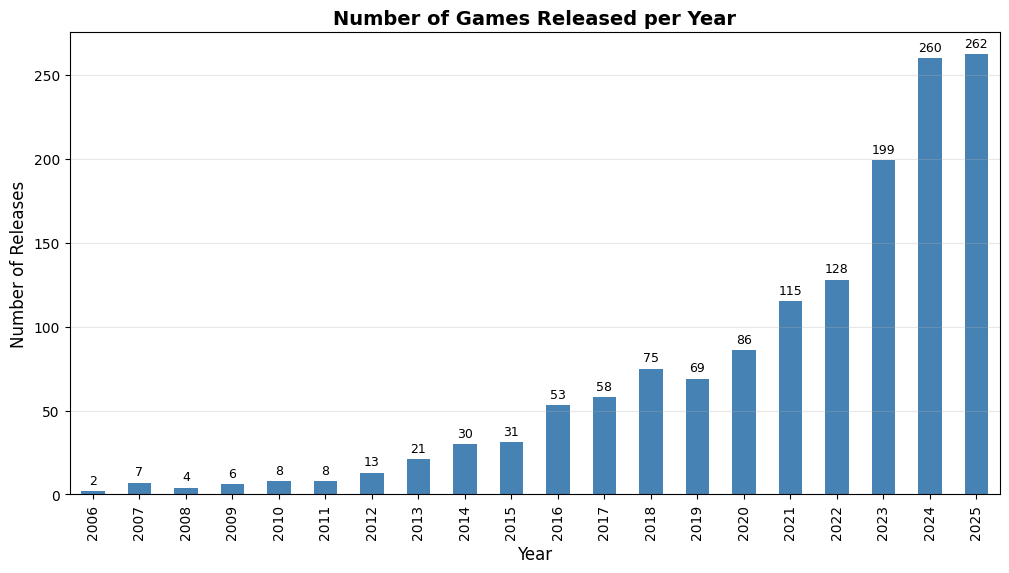

Date range: 2006 - 2025
Total games released: 1,435
Average YoY growth: 37.8%
Peak release year: 2025 with 262 games


In [491]:
# Games released per year.
releases_per_year = steam_sales.groupby('Year').size()

# Create a bar plot for releases. 
plt.figure(figsize=(12, 6))
bar_plt = releases_per_year.plot(kind='bar', color='steelblue')
plt.title('Number of Games Released per Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Releases', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Annotate each bar with its value.
for bar in bar_plt.patches:
    value = bar.get_height()
    bar_plt.annotate(f"{int(value):,}",
                (bar.get_x() + bar.get_width() / 2, value),
                ha='center', va='bottom', fontsize=9,
                xytext=(0, 3), textcoords='offset points')

# Save & show figure. (Requires output folder)
plt.savefig('output/hist_Releases_Per_Year.png', dpi=150)
plt.show()

# Summary statistics.
start_year, end_year = int(releases_per_year.index.min()), int(releases_per_year.index.max())
total_games = int(releases_per_year.sum())
avg_yoy = float(releases_per_year.sort_index().pct_change().dropna().mean() * 100)
peak_year, peak_count = int(releases_per_year.idxmax()), int(releases_per_year.max())

print(f"Date range: {start_year} - {end_year}")
print(f"Total games released: {total_games:,}")
print(f"Average YoY growth: {avg_yoy:.1f}%")
print(f"Peak release year: {int(releases_per_year.idxmax())} with {int(releases_per_year.max())} games")


**Growth insights:**
  - Annual releases trend upward over time, indicating Steam's explosive growth. 
  - Recent years show significantly higher output; with 2025 already having the most releases. 
  - Positive average YoY growth confirms sustained & growing momentum.

#### **Question 2: How have game prices evolved?**
We'll map both the yearly average and median of Original Price (€) to visualize pricing trends over time.

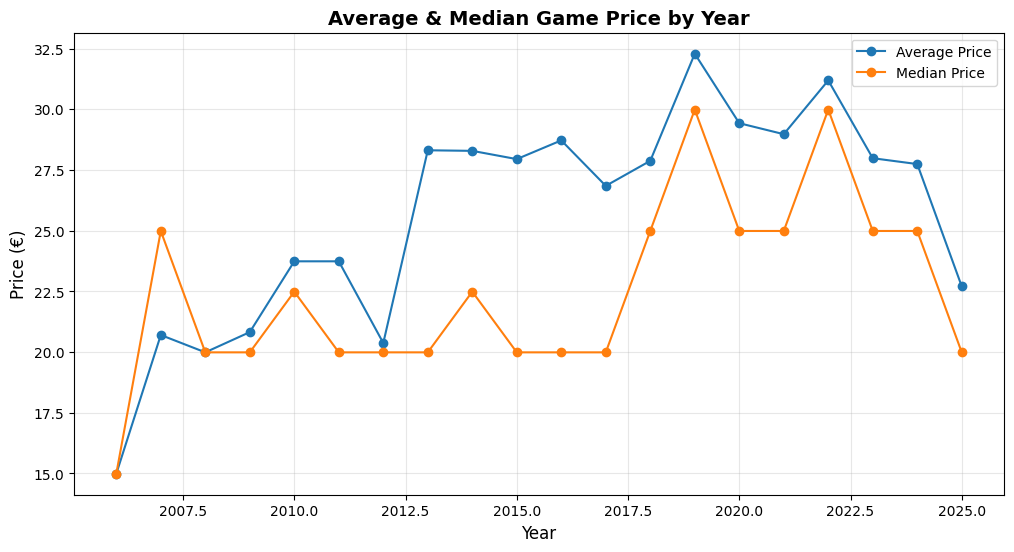

Overall average price: €27.40
Overall median price: €24.99
Avg price change per year (trend slope): €0.53/yr


In [492]:
# Yearly average and median prices.
price_by_year = steam_sales.groupby('Year')['Original Price (€)'].agg(['mean', 'median']).sort_index()

# Plotting average & median Original Price. 
plt.figure(figsize=(12, 6))
plt.plot(price_by_year.index, price_by_year['mean'], label='Average Price', color='tab:blue', marker='o')
plt.plot(price_by_year.index, price_by_year['median'], label='Median Price', color='tab:orange', marker='o')
plt.title('Average & Median Game Price by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (€)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Save and show figure. 
plt.savefig('output/avg_median_price_by_year.png', dpi=150)
plt.show()

# Summary statistics.
start_year, end_year = int(price_by_year.index.min()), int(price_by_year.index.max())
avg_overall = steam_sales['Original Price (€)'].mean()
median_overall = steam_sales['Original Price (€)'].median()
z = np.polyfit(price_by_year.index, price_by_year['mean'], 1) # Compute linear trend of average price.
trend_slope = z[0]

print(f"Overall average price: €{avg_overall:.2f}")
print(f"Overall median price: €{median_overall:.2f}")
print(f"Avg price change per year (trend slope): €{trend_slope:.2f}/yr")


**Pricing insights:**
  - Average and median prices move together, suggesting a relatively stable distribution.
  - A modest upward trend in average price indicates gradual price increases over time.

#### **Question 3: How have ratings changed over time?**
Here we'll be plotting annual average ratings to visualize potential player sentiment trends. 


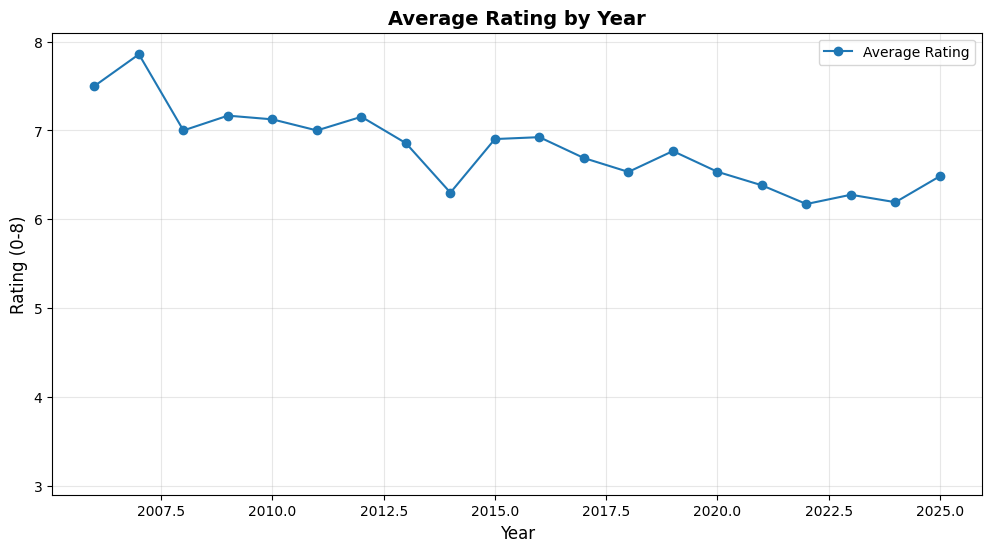

Average rating overall: 6.45/8
Avg rating change per year (trend slope): -0.065 points/yr


In [493]:
# Average ratings by year.
ratings_by_year = steam_sales.groupby('Year')['Rating'].mean().sort_index()

# Plotting average annual ratings. 
plt.figure(figsize=(12, 6))
plt.plot(ratings_by_year.index, ratings_by_year.values, label='Average Rating', color='tab:blue', marker='o')
plt.title('Average Rating by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rating (0-8)', fontsize=12)
plt.ylim(steam_sales['Rating'].min() - 0.1, steam_sales['Rating'].max() + 0.1)
plt.grid(alpha=0.3)
plt.legend()

# Save & show figure. 
plt.savefig('output/avg_rating_by_year.png', dpi=150)
plt.show()

# Summary statistics.
start_year, end_year = int(ratings_by_year.index.min()), int(ratings_by_year.index.max())
z = np.polyfit(ratings_by_year.index, ratings_by_year.values, 1)
trend_slope = z[0]

print(f"Average rating overall: {steam_sales['Rating'].mean():.2f}/8")
print(f"Avg rating change per year (trend slope): {trend_slope:.3f} points/yr")


**Ratings insights:**
  - Average ratings are overall stable year to year with a mild downward trend.
  - Limited variation suggests consistent quality bands across releases.

#### **Question 4: How has platform support changed over time?**
For our final visual, we'll plot each operating system, with the number of games for each, annually.  


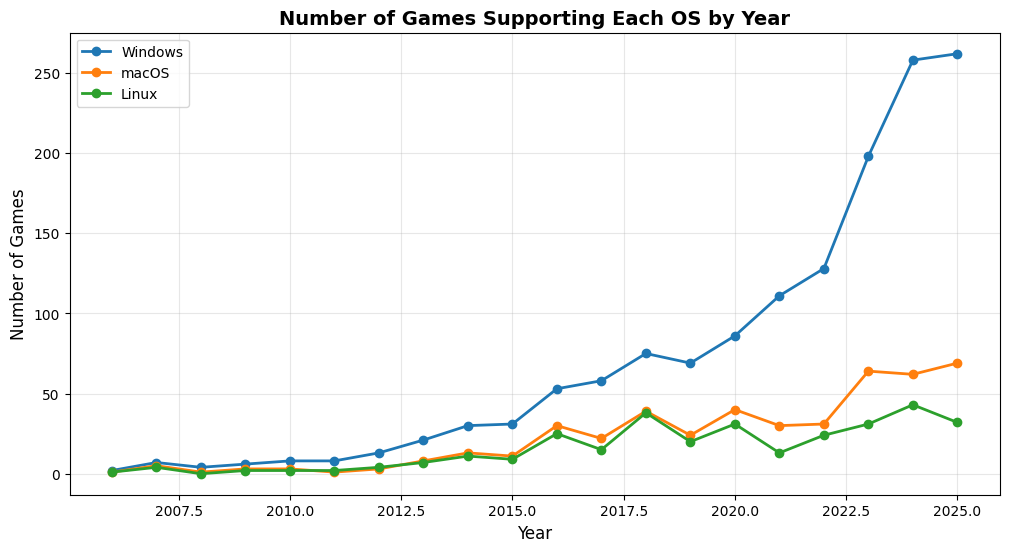

Support percentages:  Windows: 100.0%, macOS: 26.3%, Linux: 12.2%


In [494]:
# Platform support by year, (Windows, macOS, Linux).
platform_counts = steam_sales.groupby('Year').agg({
    'Windows': 'sum',
    'MacOS': 'sum',
    'Linux': 'sum',
    'Release Date': 'count'
}).rename(columns={'Release Date': 'Total_Releases'}).sort_index()

# Visualizing OS support, annually. 
plt.figure(figsize=(12, 6))
plt.plot(platform_counts.index, platform_counts['Windows'], label='Windows', marker='o', linewidth=2)
plt.plot(platform_counts.index, platform_counts['MacOS'], label='macOS', marker='o', linewidth=2)
plt.plot(platform_counts.index, platform_counts['Linux'], label='Linux', marker='o', linewidth=2)
plt.title('Number of Games Supporting Each OS by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Save & show figure. 
plt.savefig('output/platform_support_by_year.png', dpi=150)
plt.show()

# Summary statistics. 
latest_year = int(platform_counts.index.max())
row = platform_counts.loc[latest_year]
win_pct = (row['Windows'] / row['Total_Releases']) * 100
mac_pct = (row['MacOS'] / row['Total_Releases']) * 100
linux_pct = (row['Linux'] / row['Total_Releases']) * 100

print(f"Support percentages:  Windows: {win_pct:.1f}%, macOS: {mac_pct:.1f}%, Linux: {linux_pct:.1f}%")


**Platform insights:**
- Windows remains dominant, with macOS and Linux support growing gradually.
- The latest year shows macOS/Linux reaching a meaningful share of releases.

## Section 3: Wrapping Up

##### **Executive Summary**:

- 1️⃣ Steam has expanded significantly in annual releases, with sustained positive YoY growth and recent peak output.
- 2️⃣ Prices show a gradual upward trend; average and median track closely, indicating stable distribution.
- 3️⃣ Average ratings are stable to slightly declining, suggesting consistent quality bands overall.
- 4️⃣ Platform support is broadening beyond Windows, with steady gains for macOS and Linux. Although Windows still dominates by a large margin. 

In [495]:
print("-----------------------------------------------------------------")
print(f"Date range: {start_year} - {end_year}")
print(f"Total games released: {total_games:,}")
print("-----------------------------------------------------------------")
print(f"Average YoY growth: {avg_yoy:.1f}%")
print(f"Peak release year: {int(releases_per_year.idxmax())} with {int(releases_per_year.max())} games")
print("-----------------------------------------------------------------")
print(f"Overall average price: €{avg_overall:.2f}")
print(f"Overall median price: €{median_overall:.2f}")
print(f"Avg price change per year: €{trend_slope:.2f}/yr")
print("-----------------------------------------------------------------")
print(f"Average rating overall: {steam_sales['Rating'].mean():.2f}/8")
print(f"Avg rating change per year: {trend_slope:.3f} points/yr")
print("-----------------------------------------------------------------")
print(f"Support percentages:  Windows: {win_pct:.1f}%, macOS: {mac_pct:.1f}%, Linux: {linux_pct:.1f}%")
print("-----------------------------------------------------------------")

-----------------------------------------------------------------
Date range: 2006 - 2025
Total games released: 1,435
-----------------------------------------------------------------
Average YoY growth: 37.8%
Peak release year: 2025 with 262 games
-----------------------------------------------------------------
Overall average price: €27.40
Overall median price: €24.99
Avg price change per year: €-0.07/yr
-----------------------------------------------------------------
Average rating overall: 6.45/8
Avg rating change per year: -0.065 points/yr
-----------------------------------------------------------------
Support percentages:  Windows: 100.0%, macOS: 26.3%, Linux: 12.2%
-----------------------------------------------------------------


## Conclusion
**Insights & Takeaways:**
- Steam’s catalog has expanded drastically. With annual releases rapidly increasing each year, and positive average YoY growth, our first visual reveals an explosion in popularity. 
- Prices show a modest long‑run increase, with average price rising slightly year over year. 
- Average ratings appear broadly stable with a slight downward drift, suggesting consistent quality bands despite scale. 
- Platform support remains Windows‑dominant by a significant margin, but macOS and Linux have steadily gained share, improving accessibility. 

Overall, I'm very happy with the results of this project. While this is only a scratch on the surface of making a full scale analysis, it's clear that Steam has had, and continues to have massive growth.


**Limitations:**
- Dataset was updated on September 8th, 2025; weekly updates may introduce minor drift.
- Prices are in Euros & nominal (not inflation‑adjusted); regional pricing and discounts aren’t normalized.
- Ratings are aggregated, and unclear how they translate & display on the Steam store. 

**Future work:**
- Adjust prices for inflation.
- Incorporate discounting behavior and time since release effects.
- Segment ratings column by platform support and price tiers to reveal interactions.
- Investigate downward drift of ratings over time.
- Account for duplicates, and dataset updates. 

**References:**
- Dataset on Kaggle (updated weekly): https://www.kaggle.com/datasets/benjaminlundkvist/steam-sales-historical-dataset.
- matplotlib.pyplot.annotate: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
- matplotlib.pyplot.savefig: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html